# Air Quality Analyis of an Office Space
By: Sandijs Vasilevskis [Email](sandijs.vasilevskis@gmail.com)

For: MOBISTYLE Project
[LINK](https://www.mobistyle-project.eu/en/mobistyle)
[Documentation](https://data-analysis-mobistyle.readthedocs.io/en/latest/)
[GitHub](https://github.com/SVGoogle/Data-Analysis-MOBISTYLE)


## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#wrangling)
- [Exploratory Data Analysis](#eda)
- [Summary](#summary)

<a id='intro'></a>
# Introduction


> This dataset contains of time series data with almost two year long indoor air quality meausurements of an office space in building of University of Ljublana (UL) in Slovenia, Europe.

## Plotting environment setup
Choosing different colors to represent:
* MOBISTYLE and BASELINE monitoring periods
* Indoor air quality comfort catgeory ranges

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid', 
              rc={'figure.figsize': (11.7,8.27), 'xtick.major.size': 12, 'ytick.major.size': 12,
             'font.size': 14, 'axes.titlesize': 14, 'axes.labelsize': 14})

%matplotlib inline

In [16]:
# Set bins and labels
bins_TEMP, bins_RH = [-10000, 19, 20, 21, 23, 24, 25, 10000], [-10000, 20, 25, 30, 50, 60, 70, 10000]
bins_CO2, bins_VOC = [-10000, 750, 900, 1200, 10000], [-10000, 40, 80, 100, 10000]

labels_T_RH = ['Cat -IV','Cat -III', 'Cat -II','Cat I', 'Cat +II','Cat +III','Cat +IV']
labels_CO2_VOC = ['Cat I', 'Cat II', 'Cat III', 'Cat IV']

# RGB codes for Comfort category colors
cmap_T_RH = [(0, .33, .82), (0, .7, .82), (.5, .95, .75), (.3, .7, .4), (.6, .8, .4), (.95, .39, .4), (.8, .07, .25), 'lightgrey']
cmap_CO2_VOC = [(.3, .7, .4), (.6, .8, .4), (.95, .39, .4), (.8, .07, .25), 'lightgrey']

# Colors for plots
current_pallete =  sns.color_palette()
pallete = sns.color_palette().as_hex()

# Hex codes for Mobistyle and Baseline colors
color_BL = '#1f77b4'
color_MS = '#ff7f0e'
color_other = '#2ca02c'
color_out = '#7f7f7f'
color_missing = 'lightgrey'

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

<a id='wrangling'></a>
# Data Wrangling

Combine the data from office measurements with the outdoor air station data.

## Load Office Air Quality Data

In [12]:
# Select columns to load for the analysis
load_columns = list(
    ['R3N0808_OCC', 'R3N0808_WINDOW', 'R3N0808_WINDOW_Openings',
     'R3N0808_INAP_co2', 'R3N0808_INAP_humidity', 'R3N0808_INAP_voc', 
     'R3N0808_TEMP','LED', 'App', 'Monitoring_Period', 
     'Category_TEMP', 'Category_RH', 'Category_CO2', 'Category_VOC',
     'Timestamp'
    ])

# Assign categorical data types
dtypes = {
    'LED': 'category',
    'App': 'category',
    'Monitoring_Period': 'category',
    'HEAT_COOL': 'category',
    'Category_TEMP': 'category',
    'Category_RH': 'category',
    'Category_CO2': 'category',
    'Category_VOC': 'category',
}

data = (pd.read_csv(
    f'./Files/COMBINED_files/COMBINED_R3N0808.csv',
    usecols=load_columns,
    dtype=dtypes,
    parse_dates=True,
    index_col='Timestamp')
       )
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2018-02-01 00:00:00 to 2020-01-31 23:45:00
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   R3N0808_OCC              63785 non-null  float64 
 1   R3N0808_WINDOW           63785 non-null  float64 
 2   R3N0808_WINDOW_Openings  63776 non-null  float64 
 3   R3N0808_INAP_co2         53819 non-null  float64 
 4   R3N0808_INAP_humidity    53819 non-null  float64 
 5   R3N0808_INAP_voc         53819 non-null  float64 
 6   R3N0808_TEMP             64212 non-null  float64 
 7   Monitoring_Period        70080 non-null  category
 8   LED                      35136 non-null  category
 9   App                      24192 non-null  category
 10  Category_TEMP            64212 non-null  category
 11  Category_RH              53819 non-null  category
 12  Category_CO2             53819 non-null  category
 13  Category_VOC             5

### Load Outdoor Climate data

In [11]:
outdoor_data = (pd.read_csv('./Files/OUTDOOR_files/outdoor_data.csv', 
                            parse_dates=True, 
                            index_col='Timestamp')
               .rename(columns={'RH': 'Outdoor_RH', 
                                'WEATHERS_TEMP': 'Outdoor_temperature'})
               )

BL_start, BL_end = '2018-02-1', '2019-02-1'
MS_start, MS_end = '2019-02-1', '2020-02-1'

outdoor_data.loc[BL_start : BL_end, 'Monitoring_Period'] = 'BASELINE'
outdoor_data.loc[MS_start : MS_end, 'Monitoring_Period'] = 'MOBISTYLE'
outdoor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67104 entries, 2018-01-01 00:00:00 to 2019-11-30 23:45:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Outdoor_temperature  67104 non-null  float64
 1   Outdoor_RH           67104 non-null  float64
 2   Global radiation     67104 non-null  float64
 3   Diffuse radiation    67104 non-null  float64
 4   Monitoring_Period    64128 non-null  object 
dtypes: float64(4), object(1)
memory usage: 5.6+ MB


### Combine data

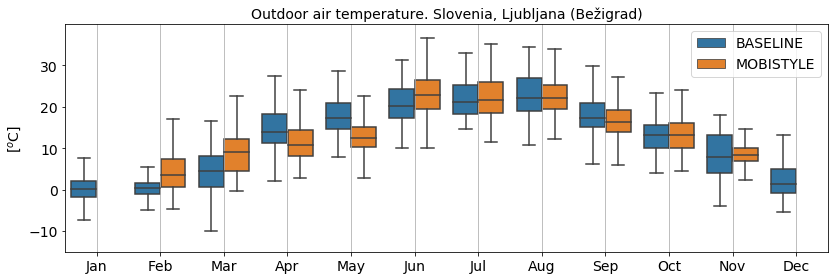

In [18]:
fig, ax = plt.subplots(figsize=(11.7, 4))

sns.boxplot(data=outdoor_data, x=outdoor_data.index.month, y='Outdoor_temperature', hue='Monitoring_Period', showfliers=False, palette=[color_BL, color_MS], ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.xaxis.grid(True)
        
ax.set_title('Outdoor air temperature. Slovenia, Ljubljana (Bežigrad)', fontsize=14)
ax.set_ylabel('[$^o$C]', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_xticklabels(pd.date_range(start='2018-1-1', periods=12, freq='MS').strftime('%b'), rotation=0)
ax.set(yticks=[-10, 0, 10, 20, 30], ylim=(-15,40))

fig.tight_layout()

### What is the structure of your dataset?

> Your answer here!

### What is/are the main feature(s) of interest in your dataset?

> Your answer here!

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Your answer here!

<a id='eda'></a>
# Exploratory Data Analysis

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

<a id='summary'></a>
# Summary

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!